In [1]:
import sympy as sm
import sympy.physics.mechanics as me
me.init_vprinting()


# Problem Description

![](https://objects-us-east-1.dream.io/mae223/2019f/mae223-l17-example-fig.png)

# Generalized coordinates

In [2]:
q1, q2, q3 = me.dynamicsymbols('q1, q2, q3')

# Generalized speeds

In [3]:
u1, u2, u3 = me.dynamicsymbols('u1, u2, u3')

# Specified Inputs

In [4]:
F, T = me.dynamicsymbols('F, T')

# Constants

In [5]:
k, c, ma, mb, mc, IB_bo, l, kT, g = sm.symbols('k, c, m_a, m_b, m_c, I_{B_bo}, l, k_T, g')
k, c, ma, mb, mc, IB_bo, l, kT, g

# Reference Frames

In [6]:
N = me.ReferenceFrame('N')

In [7]:
B = N.orientnew('B', 'Axis', (q2, N.z))

In [8]:
C = B.orientnew('C', 'Axis', (q3, N.z))

# Points

In [9]:
O = me.Point('O')

In [10]:
Pab = O.locatenew('P_{ab}', q1 * N.x)

In [11]:
Bo = Pab.locatenew('B_o', - 2 * l / 3 * B.y)

In [12]:
Pbc = Pab.locatenew('P_{bc}', -l * B.y)

In [13]:
Pc = Pbc.locatenew('P_c', -l * C.y)

In [14]:
Pc.pos_from(O)

# Linear Velocities

In [15]:
Pab.set_vel(N, Pab.pos_from(O).dt(N))
Pab.vel(N)

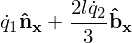

In [16]:
Bo.v2pt_theory(Pab, N, B)

In [17]:
Pbc.v2pt_theory(Pab, N, B)

In [18]:
Pc.v2pt_theory(Pbc, N, C)

# Kinematic Differential Equations

In [19]:
u1_eq = sm.Eq(u1, Pab.vel(N).dot(N.x))
u2_eq = sm.Eq(u2, Bo.vel(N).dot(B.x))
u3_eq = sm.Eq(u3, C.ang_vel_in(B).dot(B.z))

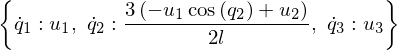

In [20]:
qdots = sm.solve([u1_eq, u2_eq, u3_eq], q1.diff(), q2.diff(), q3.diff())
qdots

Substitute expressions for the $\dot{q}$'s.

In [21]:
Pab.set_vel(N, Pab.vel(N).subs(qdots).simplify())
Pab.vel(N)

In [22]:
Bo.set_vel(N, Bo.vel(N).subs(qdots).express(B).simplify())
Bo.vel(N)

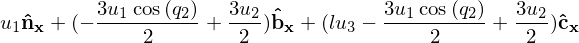

In [23]:
Pc.set_vel(N, Pc.vel(N).subs(qdots).simplify())
Pc.vel(N)

# Angular Velocities

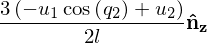

In [24]:
B.set_ang_vel(N, B.ang_vel_in(N).subs(qdots).simplify())
B.ang_vel_in(N)

In [25]:
C.set_ang_vel(B, u3 * N.z)

# Mass and Inertia

In [26]:
ma, mc

In [27]:
IB = me.inertia(B, 0, 0, IB_bo)
IB

# Loads (forces and torques)

In [28]:
Rab = (F - k*q1 - c*qdots[q1.diff()]) * N.x
Rab

In [29]:
Rbo = -(mb*g)*N.y
Rbo

In [30]:
Rc = -(mc*g)*N.y
Rc

In [31]:
TB = (T + kT*q3)*N.z
TB

# Kane's Equations (the short way)

In [32]:
kdes = [u1_eq.rhs - u1_eq.lhs,
        u2_eq.rhs - u2_eq.lhs,
        u3_eq.rhs - u3_eq.lhs]

In [33]:
block = me.Particle('block', Pab, ma)
pendulum = me.RigidBody('pendulum', Bo, B, mb, (IB, Bo))
bob = me.Particle('bob', Pc, mc)

bodies = [block, pendulum, bob]

Loads are a list of (force, point) or reference (frame, torque) 2-tuples:

In [34]:
loads = [(Pab, Rab),
         (Bo, Rbo),
         (Pc, Rc),
         (B, TB)]

In [35]:
kane = me.KanesMethod(N, (q1, q2, q3), (u1, u2, u3), kd_eqs=kdes)

In [36]:
fr, frstar = kane.kanes_equations(bodies, loads=loads)

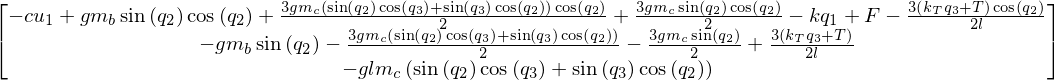

In [37]:
fr

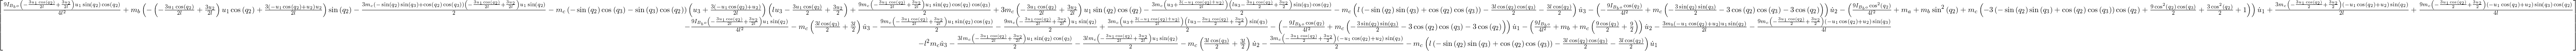

In [38]:
frstar

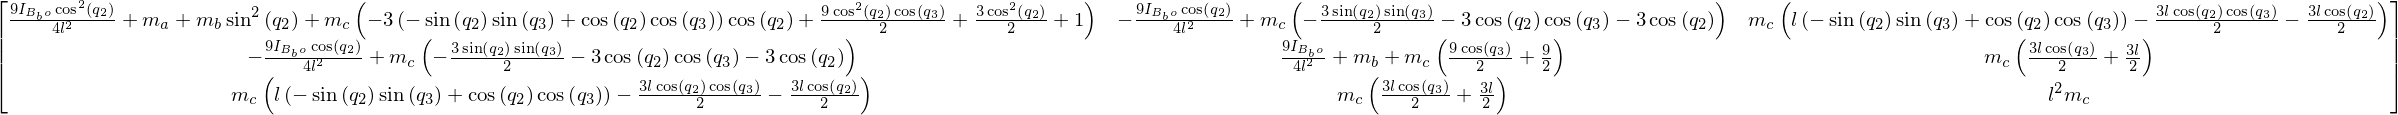

In [39]:
kane.mass_matrix

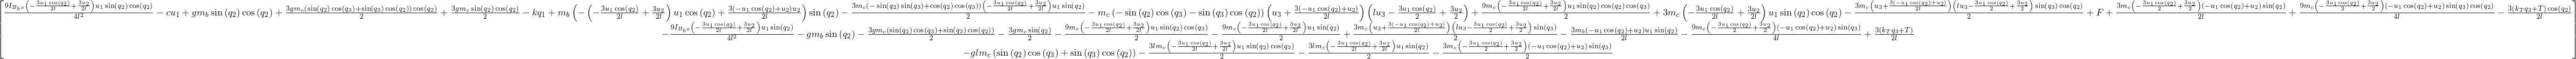

In [40]:
kane.forcing

# Simulation

In [41]:
from pydy.system import System

In [42]:
import numpy as np  # provides basic array types and some linear algebra

In [43]:
import matplotlib.pyplot as plt  # used for plots

In [44]:
sys = System(kane)

In [45]:
sys.constants = {ma: 1.0,
                 mb: 2.0,
                 mc: 1.0,
                 g: 9.81,
                 l: 2.0,
                 IB_bo: 2.0,
                 c: 10.0,
                 k: 60.0,
                 kT: 10.0}

In [46]:
sys.times = np.linspace(0.0, 20.0, num=500)

In [47]:
sys.initial_conditions = {q1: 1.0,
                          q2: 0.0,
                          q3: 0.0,
                          u1: 0.0,
                          u2: 0.0,
                          u3: 0.0}

Here are several options for specifying the force and torque using numerical values and functions that generate numerical values.

In [48]:
# this sets both specified inputs to zero for all time
specifieds = {F: 0.0,
              T: 0.0}

# this also sets both specified inputs to zero for all time
specifieds = {(F, T): np.array([0.0, 0.0])}

# this sets F to sinusoidal forcing with amplitude of 1 N and frequency of 2 * pi rad/s
# and T to zero for all time
def sin_f(x, t):
    """Returns the force F given the state vector x and time value t.
    
    Parameters
    ==========
    x : ndarray, shape(n,)
        The states in the order specified in System.states.
    t : float
        The value of time.
        
    Returns
    =======
    float
        The value of the force at time t.
    
    """
    return 1.0 * np.sin(2 * np.pi * t)


specifieds = {F: sin_f,
              T: 1.0}

# this sets both F and T to sinusoidal forcing
def sin_f_t(x, t):
    return  np.array([0.5 * np.sin(2.0 * np.pi * t),
                      2.0 * np.cos(2.0 * np.pi * t)])


specifieds = {(F, T): sin_f_t}

#system.specifieds = specifieds

In [49]:
x = sys.integrate()

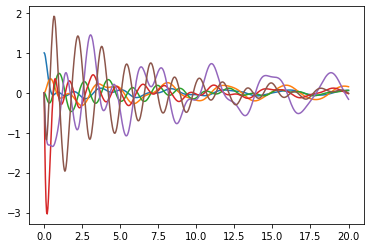

In [50]:
axes = plt.plot(sys.times, x)

Text(0, 0.5, 'Angle [deg]')

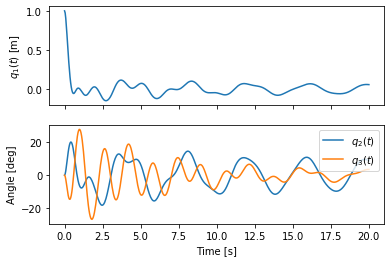

In [51]:
fig, axes = plt.subplots(2, 1, sharex=True)
axes[0].plot(sys.times, x[:, 0])
axes[0].set_ylabel('{} [m]'.format(sm.latex(q1, mode='inline')))
axes[1].plot(sys.times, np.rad2deg(x[:, 1:3]))
axes[1].legend([sm.latex(q, mode='inline') for q in (q2, q3)])
axes[1].set_xlabel('Time [s]')
axes[1].set_ylabel('Angle [deg]')

# Animate with PyDy and pythreejs

In [52]:
from pydy.viz.shapes import Cube, Cylinder, Sphere, Plane
from pydy.viz.visualization_frame import VisualizationFrame
from pydy.viz import Scene
import pythreejs as pjs

/home/moorepants/src/pydy/pydy/viz/scene.py:56: UserWarning: IPython.utils.traitlets has moved to a top-level traitlets package.
  from IPython.utils.traitlets import CFloat, List


Define some PyDy shapes for each moving object you want visible in the scene.

In [53]:
block_shape = Cube(0.25, color='red')
cpendulum_shape = Plane(l, l/4, color='blue')
spendulum_shape = Cylinder(l, 0.02, color='green')
bob_shape = Sphere(0.2, color='black')

Create a visualization frame that attaches a shape to a reference frame and point.

In [54]:
v1 = VisualizationFrame('block', N, Pab, block_shape)

v2 = VisualizationFrame('cpendulum',
                        B,
                        Pab.locatenew('Bc', -l/2*B.y),
                        cpendulum_shape)

v3 = VisualizationFrame('spendulum', 
                        C,
                        Pbc.locatenew('Cc', -l/2*C.y),
                        spendulum_shape)

v4 = VisualizationFrame('bob', C, Pc, bob_shape)

Create a scene with the origin point O and base reference frame N, then setup the scene with `create_static_html()`.

In [55]:
scene = Scene(N, O, v1, v2, v3, v4, system=sys)
scene.create_static_html(overwrite=True, silent=True)

Create PyThreeJS mesh objects that mirror the shapes already created above.

In [56]:
block_mesh = pjs.Mesh(
    pjs.BoxBufferGeometry(0.25, 0.25, 0.25),
    pjs.MeshStandardMaterial(color='red'),
    name="block"
)

cpendulum_mesh = pjs.Mesh(
    pjs.BoxBufferGeometry(height=sys.constants[l], width=sys.constants[l]/4.0, depth=0.01),
    pjs.MeshStandardMaterial(color='blue'),
    name='cpendulum'
)

spendulum_mesh = pjs.Mesh(
    pjs.CylinderBufferGeometry(radiusTop=0.02, radiusBottom=0.02, height=sys.constants[l]),
    pjs.MeshStandardMaterial(color='green'),
    name='spendulum'
)

bob_mesh = pjs.Mesh(
    pjs.SphereBufferGeometry(radius=0.2),
    pjs.MeshStandardMaterial(color='black'),
    name='bob'
)

Use the transformation matrices over time to define animation tracks for the meshes.

In [57]:
block_matrices = v1.evaluate_transformation_matrix(x, list(sys.constants.values()))
cpendulum_matrices = v2.evaluate_transformation_matrix(x, list(sys.constants.values()))
spendulum_matrices = v3.evaluate_transformation_matrix(x, list(sys.constants.values()))
bob_matrices = v4.evaluate_transformation_matrix(x, list(sys.constants.values()))

block_track = pjs.VectorKeyframeTrack(
    name='scene/block.matrix',
    times=list(sys.times),
    values=block_matrices)

cpendulum_track = pjs.VectorKeyframeTrack(
    name='scene/cpendulum.matrix',
    times=list(sys.times),
    values=cpendulum_matrices)

spendulum_track = pjs.VectorKeyframeTrack(
    name='scene/spendulum.matrix',
    times=list(sys.times),
    values=spendulum_matrices)

bob_track = pjs.VectorKeyframeTrack(
    name='scene/bob.matrix',
    times=list(sys.times),
    values=bob_matrices)

`matrixAutoUpdate` should be set to false so that we can directly manipulate the transformation matrices.

In [58]:
block_mesh.matrixAutoUpdate = False
cpendulum_mesh.matrixAutoUpdate = False
spendulum_mesh.matrixAutoUpdate = False
bob_mesh.matrixAutoUpdate = False

Set the initial orientation and position of the objects in the scene.

In [59]:
block_mesh.matrix = block_matrices[0]
cpendulum_mesh.matrix = cpendulum_matrices[0]
spendulum_mesh.matrix = spendulum_matrices[0]
bob_mesh.matrix = bob_matrices[0]

Create some axes indicators.

In [60]:
x_arrow = pjs.ArrowHelper(dir=[1, 0, 0], length=1.0, color='blue')
y_arrow = pjs.ArrowHelper(dir=[0, 1, 0], length=1.0, color='red')
z_arrow = pjs.ArrowHelper(dir=[0, 0, 1], length=1.0,color='green')

Setup the scene.

In [61]:
view_width = 800
view_height = 600

camera = pjs.PerspectiveCamera(position=[1, 1, 1],
                               aspect=view_width/view_height)
key_light = pjs.DirectionalLight(position=[0, 10, 10])
ambient_light = pjs.AmbientLight()

scene_pjs = pjs.Scene(children=[block_mesh, cpendulum_mesh, spendulum_mesh, bob_mesh,
                                x_arrow, y_arrow, z_arrow, 
                                camera, key_light, ambient_light])

controller = pjs.OrbitControls(controlling=camera)
renderer = pjs.Renderer(camera=camera, scene=scene_pjs, controls=[controller], width=view_width, height=view_height)

Show the scene:

In [62]:
renderer

Renderer(camera=PerspectiveCamera(aspect=1.3333333333333333, position=(1.0, 1.0, 1.0), quaternion=(0.0, 0.0, 0…

Setup and show the animation controls:

In [63]:
clip = pjs.AnimationClip(tracks=[block_track, cpendulum_track, spendulum_track, bob_track], duration=sys.times[-1])
action = pjs.AnimationAction(pjs.AnimationMixer(scene_pjs), clip, scene_pjs)
action

AnimationAction(clip=AnimationClip(duration=20.0, tracks=(VectorKeyframeTrack(name='scene/block.matrix', times…

# Animate with Matplotlib (mostly useful for 2D but can even do 3D)

**This is not yet complete.**

In [64]:
from matplotlib.patches import Rectangle, Circle

In [65]:
cpend_width = 0.2
cpend_length = sys.constants[l]
cpend_left_corner = Pab.locatenew('Blc', -l*B.y - cpend_width/2*B.x)
cpend_left_corner.pos_from(O).dot(N.x)

In [66]:
cpend_left_corner.pos_from(O).dot(N.y)

In [67]:
spend_left_corner = Pbc.locatenew('Clc', -l*C.y - cpend_width/2*C.x)
repr(spend_left_corner.pos_from(O).dot(N.x)).replace('cos', 'np.cos').replace('sin', 'np.sin').replace('(t)', '').replace('q1', 'x[0,1]').replace('q2', 'x[0,1]').replace('q3', 'x[0,2]')

'-l*(-np.sin(x[0,1])*np.cos(x[0,2]) - np.sin(x[0,2])*np.cos(x[0,1])) + l*np.sin(x[0,1]) + x[0,1] + 0.1*np.sin(x[0,1])*np.sin(x[0,2]) - 0.1*np.cos(x[0,1])*np.cos(x[0,2])'

In [68]:
repr(spend_left_corner.pos_from(O).dot(N.y)).replace('cos', 'np.cos').replace('sin', 'np.sin').replace('(t)', '').replace('q1', 'x[0,1]').replace('q2', 'x[0,1]').replace('q3', 'x[0,2]')

'-l*(-np.sin(x[0,1])*np.sin(x[0,2]) + np.cos(x[0,1])*np.cos(x[0,2])) - l*np.cos(x[0,1]) - 0.1*np.sin(x[0,1])*np.cos(x[0,2]) - 0.1*np.sin(x[0,2])*np.cos(x[0,1])'

In [69]:
l_val = sys.constants[l]
q1_vals = x[:, 0]
q2_vals = x[:, 1]
q3_vals = x[:, 2]

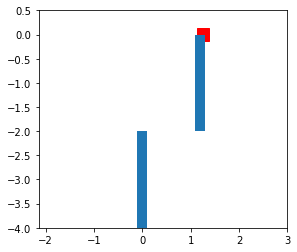

In [70]:
fig, ax = plt.subplots(1, 1)

ax.set_xlim((np.min(x[:, 0]) - sys.constants[l],
             np.max(x[:, 0]) + sys.constants[l]))

ax.set_ylim((-2*sys.constants[l], 0.5))

block = Rectangle((x[0, 0] + 0.25/2, 0.0 - 0.25/2),
                  0.25,  # width [m]
                  0.25,  # height [m]
                  color='red',
                 )

ax.add_patch(block)

cpend = Rectangle((l_val*np.sin(x[0, 1]) + x[0, 0] + cpend_width/2*np.cos(x[0, 1]),
                  -l_val*np.cos(x[0, 1]) - cpend_width/2*np.sin(x[0, 1])),
                cpend_width,
                cpend_length,
                angle=np.rad2deg(x[0, 1]),
                )

ax.add_patch(cpend)

spend = Rectangle((-l_val*(-np.sin(x[0,1])*np.cos(x[0,2]) -
                       np.sin(x[0,2])*np.cos(x[0,1])) +
                   l_val*np.sin(x[0,1]) +
                   x[0,1] +
                   0.1*np.sin(x[0,1])*np.sin(x[0,2]) -
                   0.1*np.cos(x[0,1])*np.cos(x[0,2]),
                   -l_val*(-np.sin(x[0,1])*np.sin(x[0,2]) +
                       np.cos(x[0,1])*np.cos(x[0,2])) -
                   l_val*np.cos(x[0,1]) -
                   0.1*np.sin(x[0,1])*np.cos(x[0,2]) -
                   0.1*np.sin(x[0,2])*np.cos(x[0,1])),
                cpend_width,
                cpend_length,
                angle=np.rad2deg(x[0, 1]),
                )

ax.add_patch(spend)

ax.set_aspect('equal')